In [1]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(69420)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 15})

In [3]:
import dynesty
import GPy

### Red noise (real LC):

$$ y(t) = \sum \Delta t \cdot dist $$

where $ dist \sim N(0, \sigma)$

### Tick-tock signal:

$$ y(t) = A(t) \sin (2\pi ~f(t) ~t) $$

where $ A(t) = \exp(-gt) $, $g$ is the amplitude damping factor, and $f(t) = \frac{\exp(ht)}{T_{init}}$, $h$ being the frequency damping factor and $T_{init}$ the initial period.

Q: Can we use `dynesty` to get posteriors for $g$, $h$, and $T_{init}$ and maybe even $\sigma$ for the tick-tock signal?

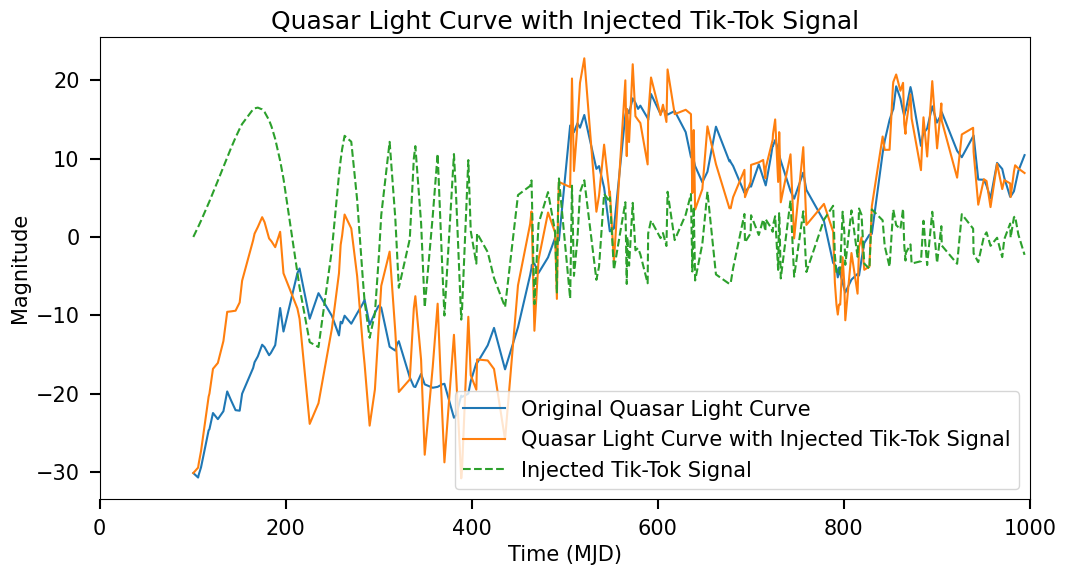

In [4]:
from scipy.interpolate import interp1d

np.random.seed(113)

def generate_red_noise(time_instances, sigma=0.1):
    delta_t = np.diff(time_instances, prepend=time_instances[0])
    disturbances = np.random.normal(scale=sigma, size=len(time_instances))
    red_noise = np.cumsum(delta_t * disturbances)
    # print(np.max(disturbances))
    return red_noise - red_noise.mean()

def generate_tiktok_signal(time_instances, initial_period, damping_factor_amplitude, damping_factor_frequency):
    frequency = np.exp(damping_factor_frequency * time_instances) / (initial_period)
    amplitude = np.exp(-damping_factor_amplitude * time_instances)
    tiktok_signal = amplitude * np.sin(2 * np.pi * frequency * time_instances)
    return tiktok_signal

def inject_tiktok_to_light_curve(real_times, real_light_curve, initial_period, damping_factor_amplitude, damping_factor_frequency, snr=None, inject_signal=False):
    if not inject_signal:
        return real_light_curve, np.zeros_like(real_light_curve)

    t = np.linspace(real_times.min(), real_times.max(), 5 * len(real_times))
    tiktok_signal_regular = generate_tiktok_signal(t - t.min(), initial_period, damping_factor_amplitude, damping_factor_frequency)

    if snr is not None:
        noise_power = np.var(real_light_curve)
        signal_power = noise_power * snr
        scale_factor = np.sqrt(signal_power)
        tiktok_signal_regular *= scale_factor

    interpolator = interp1d(t, tiktok_signal_regular, kind='linear', fill_value="extrapolate")
    tiktok_signal_interpolated = interpolator(real_times)

    combined_light_curve = real_light_curve + tiktok_signal_interpolated
    return combined_light_curve, tiktok_signal_interpolated

real_times = np.sort(np.random.uniform(100, 1000, 200))
real_light_curve = generate_red_noise(real_times, sigma=0.5)  # Adjust sigma as needed

initial_period = 500
damping_factor_amplitude = 0.002
damping_factor_frequency = 0.008
snr = 2
inject_signal = True

combined_light_curve, tiktok_signal = inject_tiktok_to_light_curve(
    real_times,
    real_light_curve,
    initial_period,
    damping_factor_amplitude,
    damping_factor_frequency,
    snr,
    inject_signal
)

plt.figure(figsize=(12, 6))
plt.plot(real_times, real_light_curve, label='Original Quasar Light Curve')
if inject_signal:
    plt.plot(real_times, combined_light_curve, label='Quasar Light Curve with Injected Tik-Tok Signal')
    plt.plot(real_times, tiktok_signal, label='Injected Tik-Tok Signal', linestyle='--')
plt.xlim(0,1000)
plt.xlabel('Time (MJD)')
plt.ylabel('Magnitude')
plt.title('Quasar Light Curve with Injected Tik-Tok Signal')
plt.legend()
plt.show()

In [5]:
print(np.log10(0.002))
print(np.log10(0.008))
print(np.log10(0.25))

-2.6989700043360187
-2.0969100130080562
-0.6020599913279624


## Simple tick-tock signal

In [6]:
def try_generate_tiktok_signal(time_instances, params):
    T_init, g = params
    frequency = 1 / (T_init)
    amplitude = np.exp(-g * time_instances)
    tiktok_signal = amplitude * np.sin(2 * np.pi * frequency * time_instances)
    return tiktok_signal

In [7]:
real_times = np.sort(rstate.uniform(100,1000,200))
trial = try_generate_tiktok_signal(real_times, (500, 0.002))

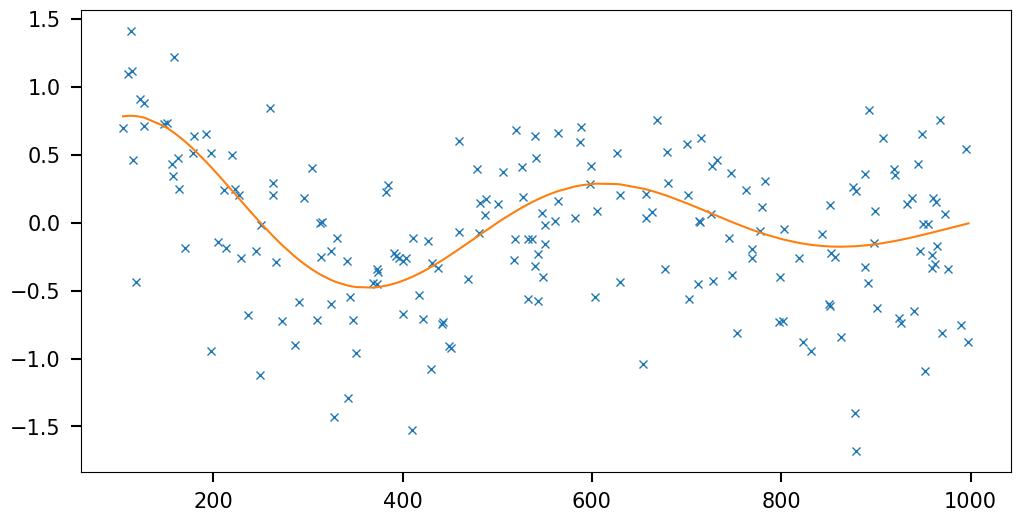

In [8]:
y = rstate.normal(trial, 0.5)
plt.figure(figsize=(12,6))
plt.plot(real_times, y, 'x')
plt.plot(real_times, trial)

In [9]:
# For tiktok signal with Gaussian noise

def prior_transform(u):
    """transforms from unit cube u~[0,1) to the variables 
    log g, log h, T_init, log sigma (in order)"""
    v = u * 100
    v[0] = 5 * (u[0] * 2 - 1)
#     v[1] = 5 * (u[1] * 2 - 1)
    v[1] = 5 * (u[1] * 2 - 1)
    v[2] = 5 * (u[2] * 2 - 1)
    return v

def loglike(v):
    logg, logT_init, logsigma = v
    g, T_init, sigma = (10**logg, 10**logT_init, 10**logsigma)
    # Create instances of the tiktok signal with different parameters
    real_times = np.sort(np.random.uniform(100, 1000, 200))
    ypred = try_generate_tiktok_signal(real_times, (T_init, g))
    residsq = (ypred - y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e300
        
    return loglike

In [11]:
# sample
sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=3,
                                bound='multi', sample='rwalk', nlive=2000,
                               rstate=rstate, walks=25)
sampler.run_nested()
res = sampler.results

51498it [32:51, 26.12it/s, batch: 0 | bound: 2975 | nc: 1 | ncall: 22378546 | eff(%):  0.230 | loglstar:   -inf < -132.259 <    inf | logz: -152.399 +/-  0.087 | dlogz:  0.000 >  0.010]    


In [12]:
# sampler for posterior estimation
sampler.reset()
sampler.run_nested(nlive_init=500, nlive_batch=500, wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0}, maxiter=10000)
respos = sampler.results

10001it [00:33, 111.93it/s, batch: 0 | bound: 132 | nc: 100 | ncall: 264752 | eff(%):  3.770 | loglstar:   -inf < -135.574 <    inf | logz: -153.010 +/-  0.174 | dlogz:  0.500 >  0.010]   /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/sampler.py:756: UserWarning:The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
10501it [00:33, 312.02it/s, batch: 0 | bound: 132 | nc: 1 | ncall: 265252 | eff(%):  3.959 | loglstar:   -inf < -133.464 <    inf | logz: -152.893 +/-  0.194 | dlogz:  0.001 >  0.010]  


In [13]:
from dynesty import plotting as dyplot

dyplot.runplot(res)
plt.tight_layout()

In [14]:
labels = [r'$\log g$', r'$T_{init}$', r'$\log \sigma$']
truths = [np.log10(0.002), np.log10(500), np.log10(0.5)]
fig, axes = dyplot.traceplot(res, labels=labels, truths=truths,
                             fig=plt.subplots(3, 2, figsize=(16, 25)))
fig.tight_layout()

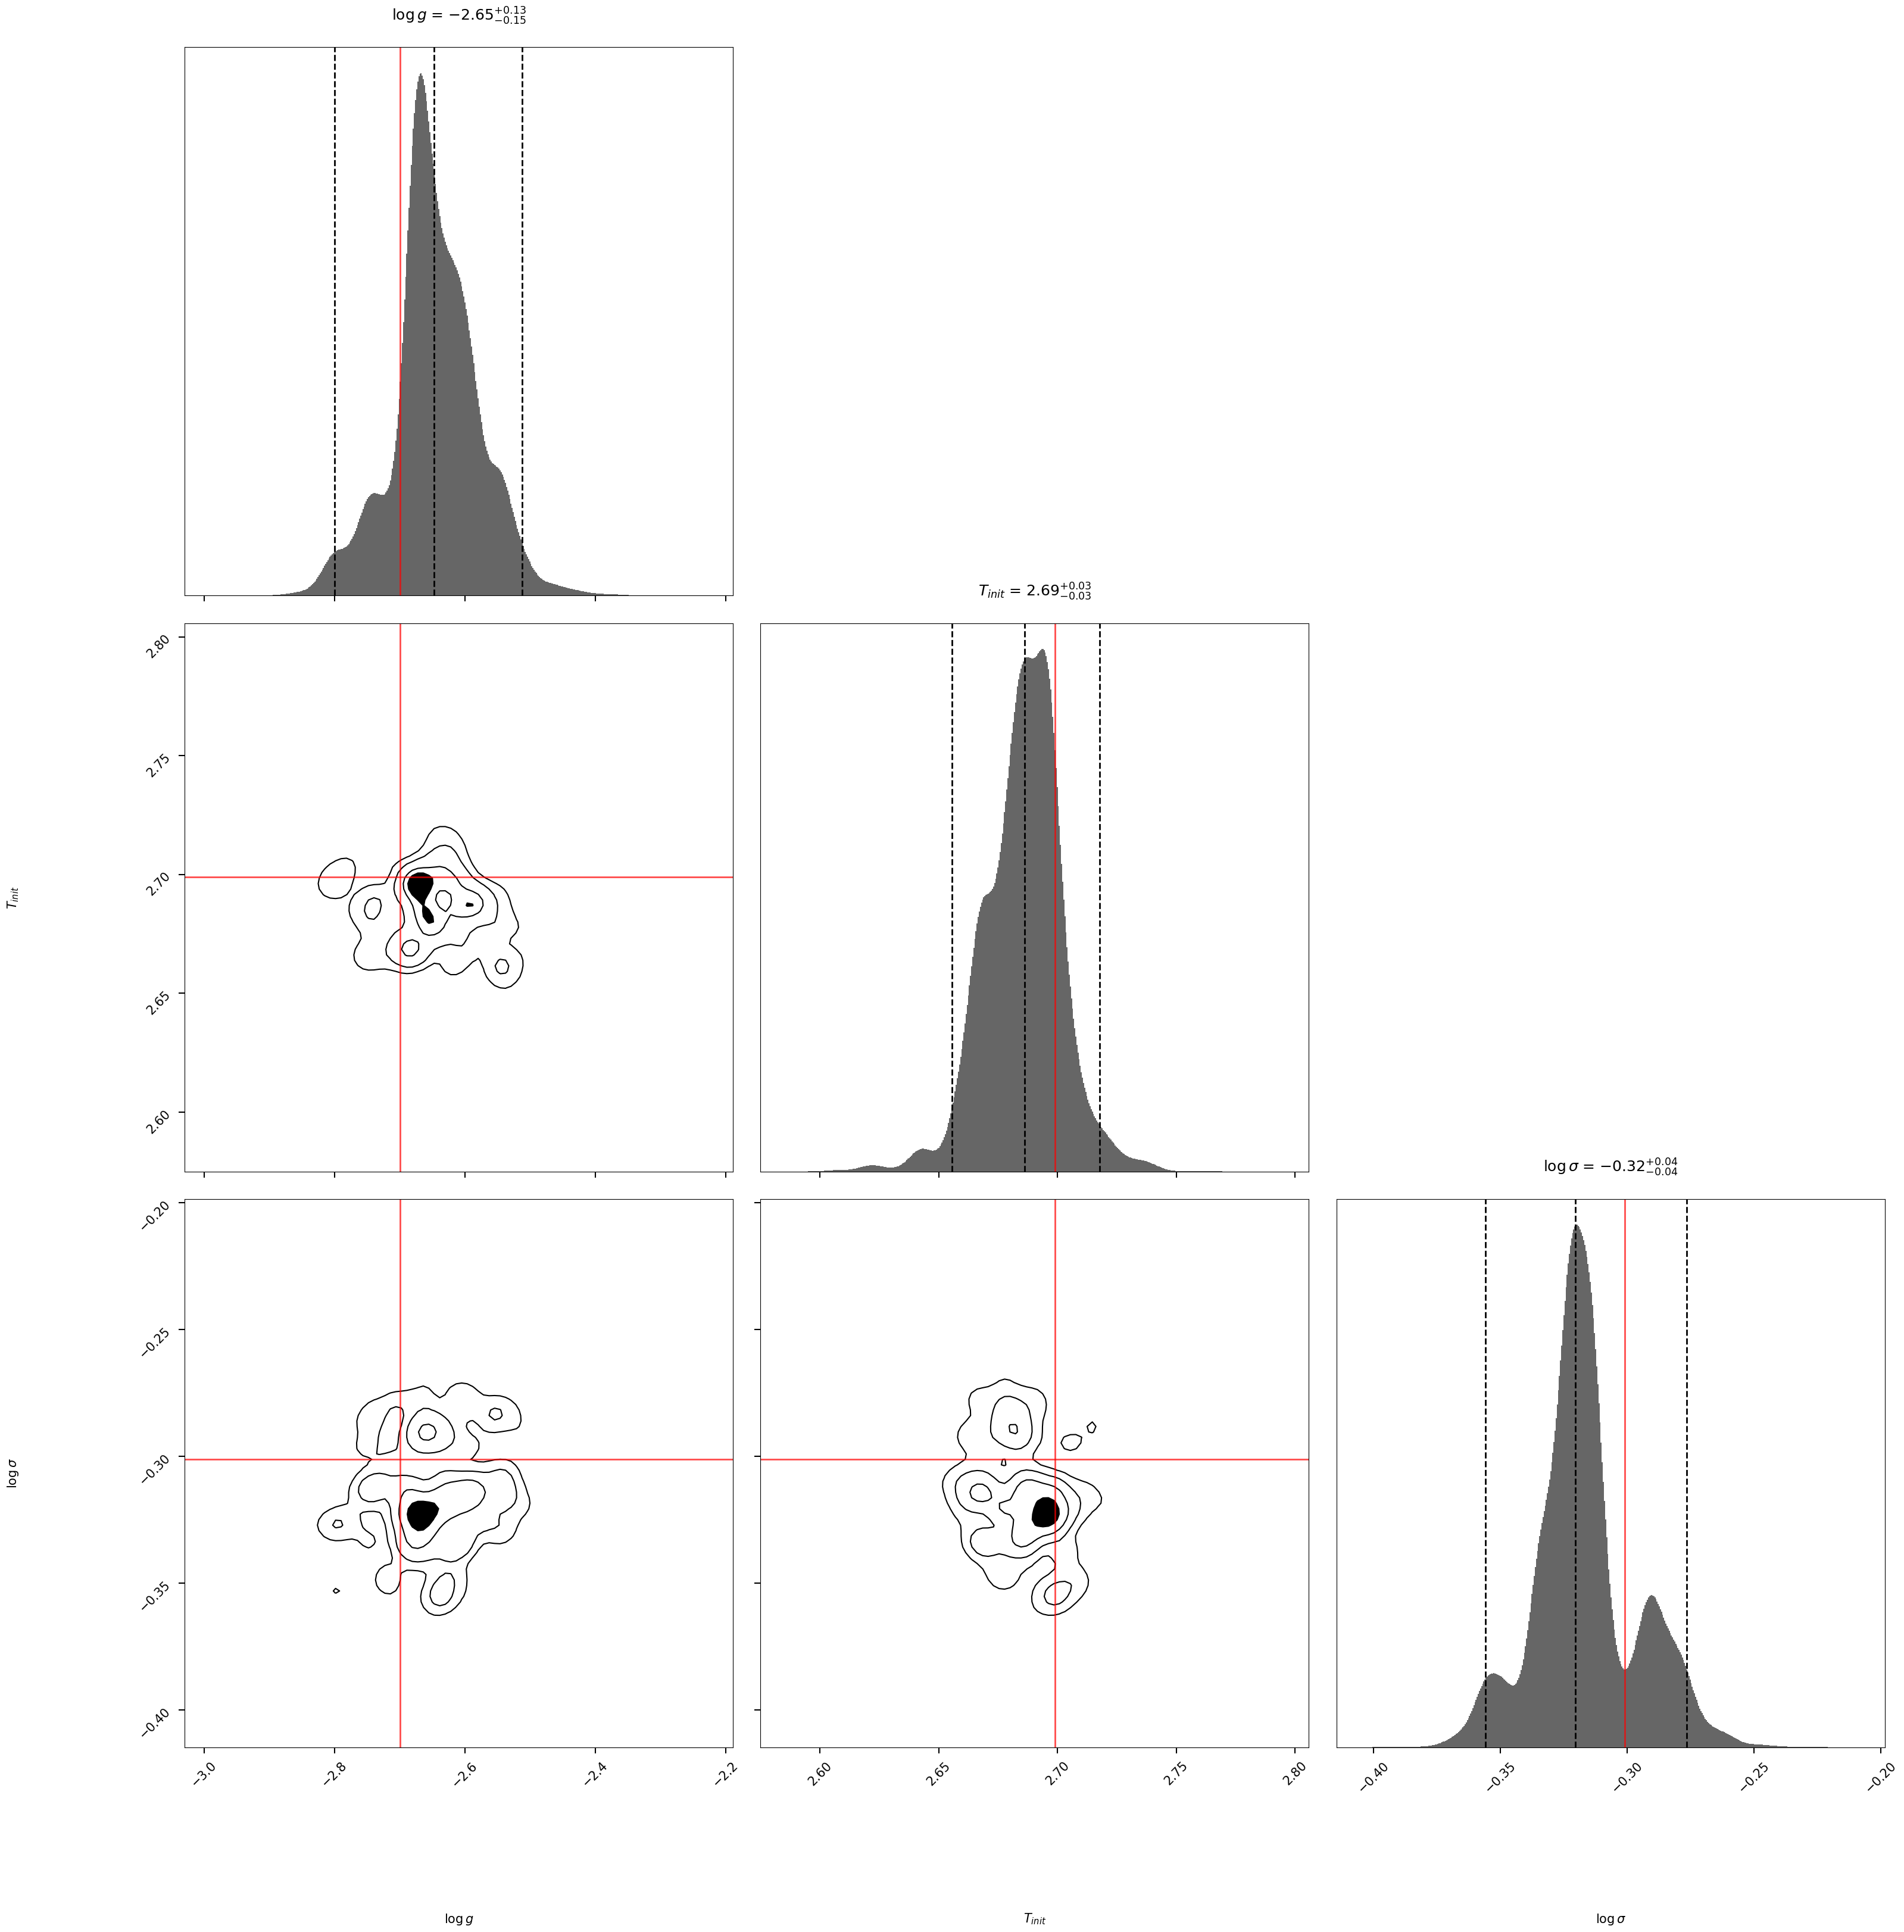

In [15]:
fig, axes = dyplot.cornerplot(respos, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(3,3, figsize=(35, 35)))

## More complicated tick-tock signal

(0.0, 1000.0)

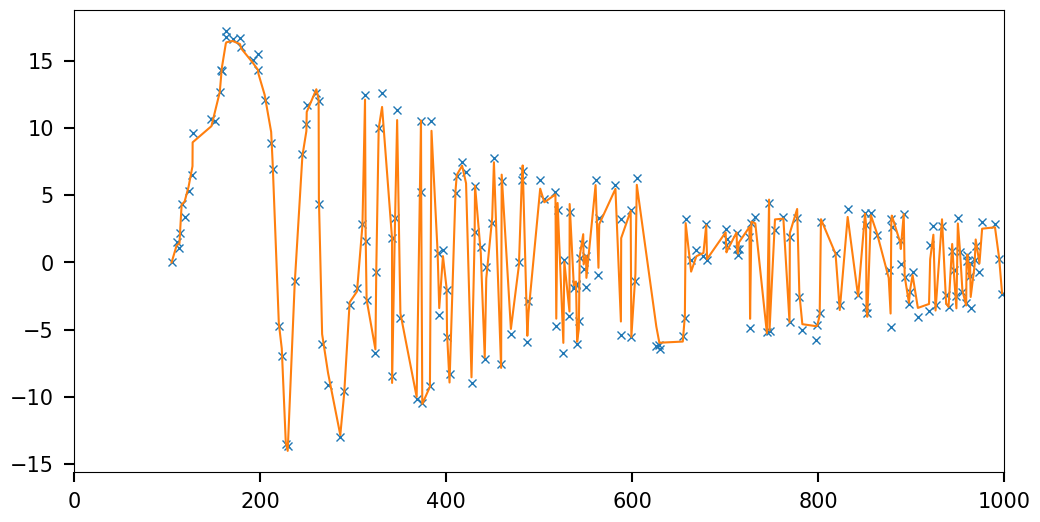

In [16]:
y = rstate.normal(tiktok_signal, 0.5)
plt.figure(figsize=(12,6))
plt.plot(real_times, y, 'x')
plt.plot(real_times, tiktok_signal)
plt.xlim(0,1000)

In [17]:
def prior_transform(u):
    """transforms from unit cube u~[0,1) to the variables 
    log g, log h, T_init, log sigma (in order)"""
    v = u * 100
    v[0] = 5 * (u[0] * 2 - 1) # log g = [10^-2, 10^2]
    v[1] = 5 * (u[1] * 2 - 1)
    v[2] = 5 * (u[2] * 2 - 1)
    v[3] = 5 * (u[3] * 2 - 1)
    return v

def loglike(v):
    logg, logh, logT_init, logsigma = v
    g, h, T_init, sigma = (10**logg, 10**logh, 10**logT_init, 10**logsigma)
    ypred = generate_tiktok_signal(real_times, T_init, g, h)
    residsq = (ypred - y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e300
        
    return loglike

In [18]:
# sample
sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=4,
                                bound='multi', sample='rslice', nlive=2000,
                               rstate=rstate)
sampler.run_nested()
res = sampler.results

0it [00:00, ?it/s] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
6529it [00:09, 234.27it/s, batch: 0 | bound: 0 | nc: 86 | ncall: 62655 | eff(%): 10.098 | loglstar:   -inf < -748.295 <    inf | logz: -756.638 +/-    nan | dlogz: 103.105 >  0.010]         /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
6554it [00:09, 140.38it/s, batch: 0 | bound: 1 | nc: 30 | ncall: 63631 | eff(%):  9.986 | loglstar:   -inf < -746.162 <    inf | logz: -754.717 +/-    nan | dlogz: 101.190 >  0.010] /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel

14833it [00:48, 56.24it/s, batch: 0 | bound: 14 | nc: 59 | ncall: 435248 | eff(%):  3.392 | loglstar:   -inf < -654.137 <    inf | logz: -660.244 +/-    nan | dlogz:  4.909 >  0.010]  /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/sampling.py:420: UserWarning:The slice sample interval was expanded more than 1000 times
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/sampling.py:684: UserWarning:Enabling doubling strategy of slice sampling from Neal(2003)
14857it [00:48, 71.74it/s, batch: 0 | bound: 14 | nc: 43 | ncall: 438213 | eff(%):  3.375 | loglstar:   -inf < -654.137 <    inf | logz: -660.241 +/-    nan | dlogz:  4.894 >  0.010] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
15088it [00:50, 162.63it/s, batch: 0 | bound: 14 | nc: 61 | ncall: 455009 | eff(%):  3.301 | loglstar:   -inf < -654.134 <    inf | logz: -660.217 +/-    nan | dlogz:  4.756 >  0.010]  /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflo

18592it [01:20, 126.79it/s, batch: 0 | bound: 25 | nc: 54 | ncall: 740031 | eff(%):  2.506 | loglstar:   -inf < -652.501 <    inf | logz: -659.981 +/-    nan | dlogz:  3.138 >  0.010] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
18898it [01:22, 95.79it/s, batch: 0 | bound: 26 | nc: 70 | ncall: 764956 | eff(%):  2.464 | loglstar:   -inf < -652.285 <    inf | logz: -659.960 +/-    nan | dlogz:  2.972 >  0.010]   /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
18918it [01:23, 116.15it/s, batch: 0 | bound: 26 | nc: 55 | ncall: 766184 | eff(%):  2.463 | loglstar:   -inf < -652.273 <    inf | logz: -659.959 +/-    nan | dlogz:  2.962 >  0.010] /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
18967it [01:23, 137.59it/s, batch: 0 | bound: 26 | nc: 49 | ncall: 769893 | eff(%):  2.457 | loglstar:   -inf

22693it [01:49, 178.84it/s, batch: 0 | bound: 35 | nc: 75 | ncall: 1044222 | eff(%):  2.169 | loglstar:   -inf < -650.319 <    inf | logz: -659.688 +/-    nan | dlogz:  1.337 >  0.010]  /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
22765it [01:50, 143.79it/s, batch: 0 | bound: 36 | nc: 58 | ncall: 1049563 | eff(%):  2.165 | loglstar:   -inf < -650.298 <    inf | logz: -659.684 +/-    nan | dlogz:  1.307 >  0.010] /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
23083it [01:52, 90.04it/s, batch: 0 | bound: 37 | nc: 60 | ncall: 1073397 | eff(%):  2.146 | loglstar:   -inf < -650.206 <    inf | logz: -659.667 +/-    nan | dlogz:  1.182 >  0.010]   /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
 /tmp/ipykernel_8289/

29696it [02:36, 153.95it/s, batch: 0 | bound: 52 | nc: 43 | ncall: 1515956 | eff(%):  1.956 | loglstar:   -inf < -649.046 <    inf | logz: -659.531 +/-    nan | dlogz:  0.216 >  0.010]  /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
29874it [02:37, 132.59it/s, batch: 0 | bound: 53 | nc: 62 | ncall: 1528661 | eff(%):  1.952 | loglstar:   -inf < -649.003 <    inf | logz: -659.530 +/-    nan | dlogz:  0.200 >  0.010]  /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
31522it [02:49, 151.81it/s, batch: 0 | bound: 57 | nc: 43 | ncall: 1645707 | eff(%):  1.913 | loglstar:   -inf < -648.670 <    inf | logz: -659.523 +/-    nan | dlogz:  0.092 >  0.010]  /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel_8289/2

In [19]:
# sampler for posterior estimation
sampler.reset()
sampler.run_nested(nlive_init=500, nlive_batch=500, wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0})
respos = sampler.results

0it [00:00, ?it/s] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
1676it [00:02, 313.91it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 16105 | eff(%): 10.093 | loglstar:   -inf < -748.628 <    inf | logz: -757.758 +/-    nan | dlogz: 104.613 >  0.010]        /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
 /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
1798it [00:03, 256.09it/s, batch: 0 | bound: 1 | nc: 61 | ncall: 23106 | eff(%):  7.617 | loglstar:   -inf < -714

3383it [00:10, 173.88it/s, batch: 0 | bound: 15 | nc: 55 | ncall: 115019 | eff(%):  2.929 | loglstar:   -inf < -654.208 <    inf | logz: -660.557 +/-    nan | dlogz:  3.815 >  0.010] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
3474it [00:11, 172.90it/s, batch: 0 | bound: 15 | nc: 50 | ncall: 120894 | eff(%):  2.862 | loglstar:   -inf < -654.174 <    inf | logz: -660.470 +/-    nan | dlogz:  3.553 >  0.010] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
3492it [00:11, 143.13it/s, batch: 0 | bound: 16 | nc: 48 | ncall: 122088 | eff(%):  2.849 | loglstar:   -inf < -654.168 <    inf | logz: -660.455 +/-    nan | dlogz:  3.504 >  0.010] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
3591it [00:12, 175.36it/s, b

 /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
4667it [00:20, 111.64it/s, batch: 0 | bound: 28 | nc: 46 | ncall: 213110 | eff(%):  2.185 | loglstar:   -inf < -652.428 <    inf | logz: -660.026 +/-    nan | dlogz:  2.348 >  0.010]  /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
4711it [00:20, 123.77it/s, batch: 0 | bound: 29 | nc: 63 | ncall: 216706 | eff(%):  2.169 | loglstar:   -inf < -652.286 <    inf | logz: -660.013 +/-    nan | dlogz:  2.258 >  0.010] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
4743it [00:21, 130.94it/s, batch: 0 | bound: 29 | nc: 29 | ncall: 219146 | eff(%):  2.159 | loglstar:   -inf < -652.205 < 

6233it [00:29, 184.30it/s, batch: 0 | bound: 42 | nc: 58 | ncall: 309830 | eff(%):  2.009 | loglstar:   -inf < -649.715 <    inf | logz: -659.596 +/-    nan | dlogz:  0.472 >  0.010] /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
6253it [00:29, 172.89it/s, batch: 0 | bound: 42 | nc: 85 | ncall: 311099 | eff(%):  2.007 | loglstar:   -inf < -649.699 <    inf | logz: -659.594 +/-    nan | dlogz:  0.456 >  0.010] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
6373it [00:30, 189.83it/s, batch: 0 | bound: 43 | nc: 45 | ncall: 318485 | eff(%):  1.998 | loglstar:   -inf < -649.621 <    inf | logz: -659.581 +/-    nan | dlogz:  0.371 >  0.010] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
6510it [00:31, 156.64it/s, ba

11827it [01:00, 211.56it/s, batch: 4 | bound: 3 | nc: 105 | ncall: 632929 | eff(%):  1.788 | loglstar: -656.302 < -655.057 < -650.235 | logz: -659.514 +/-  0.104 | stop:  1.552] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
 /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
11953it [01:00, 224.28it/s, batch: 4 | bound: 4 | nc: 37 | ncall: 640266 | eff(%):  1.787 | loglstar: -656.302 < -654.670 < -650.235 | logz: -659.514 +/-  0.104 | stop:  1.552]  /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarni

13416it [01:06, 208.95it/s, batch: 4 | bound: 18 | nc: 74 | ncall: 739425 | eff(%):  1.747 | loglstar: -656.302 < -653.144 < -650.235 | logz: -659.514 +/-  0.104 | stop:  1.552] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:invalid value encountered in sin
13438it [01:06, 192.42it/s, batch: 4 | bound: 19 | nc: 82 | ncall: 741359 | eff(%):  1.746 | loglstar: -656.302 < -653.091 < -650.235 | logz: -659.514 +/-  0.104 | stop:  1.552] /tmp/ipykernel_8289/2002232062.py:15: RuntimeWarning:overflow encountered in multiply
13509it [01:07, 213.57it/s, batch: 4 | bound: 19 | nc: 134 | ncall: 747563 | eff(%):  1.741 | loglstar: -656.302 < -652.911 < -650.235 | logz: -659.514 +/-  0.104 | stop:  1.552] /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
 /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in exp
 /tmp/ipykernel_8289/2002232062.py:15: Runtim

 /tmp/ipykernel_8289/2002232062.py:13: RuntimeWarning:overflow encountered in divide
15179it [01:12, 210.57it/s, batch: 4 | bound: 31 | nc: 1 | ncall: 832083 | eff(%):  1.765 | loglstar: -656.302 < -648.506 < -650.235 | logz: -659.514 +/-  0.104 | stop:  0.995] 


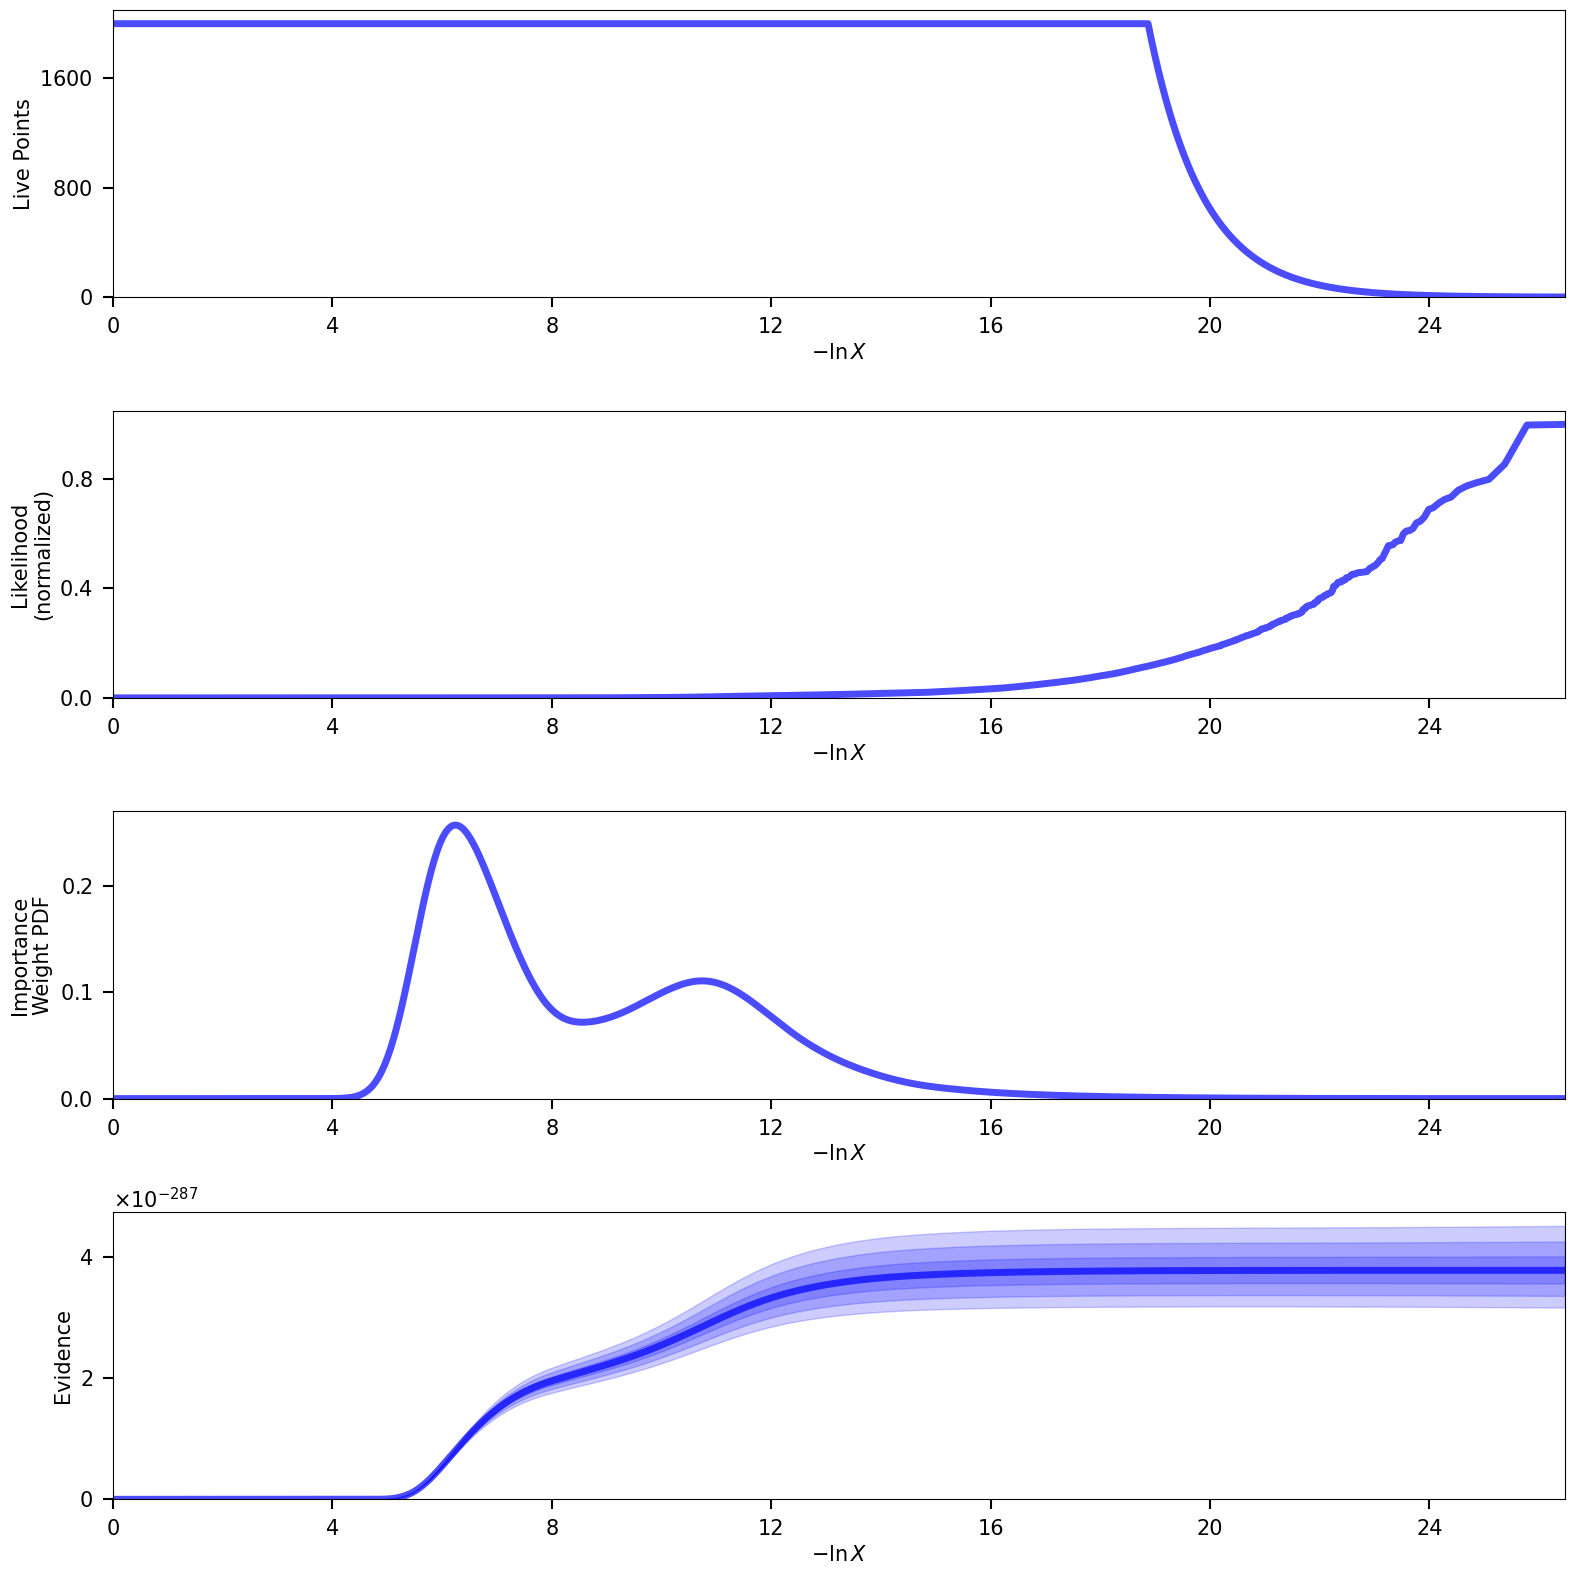

In [20]:
from dynesty import plotting as dyplot

dyplot.runplot(res)
plt.tight_layout()

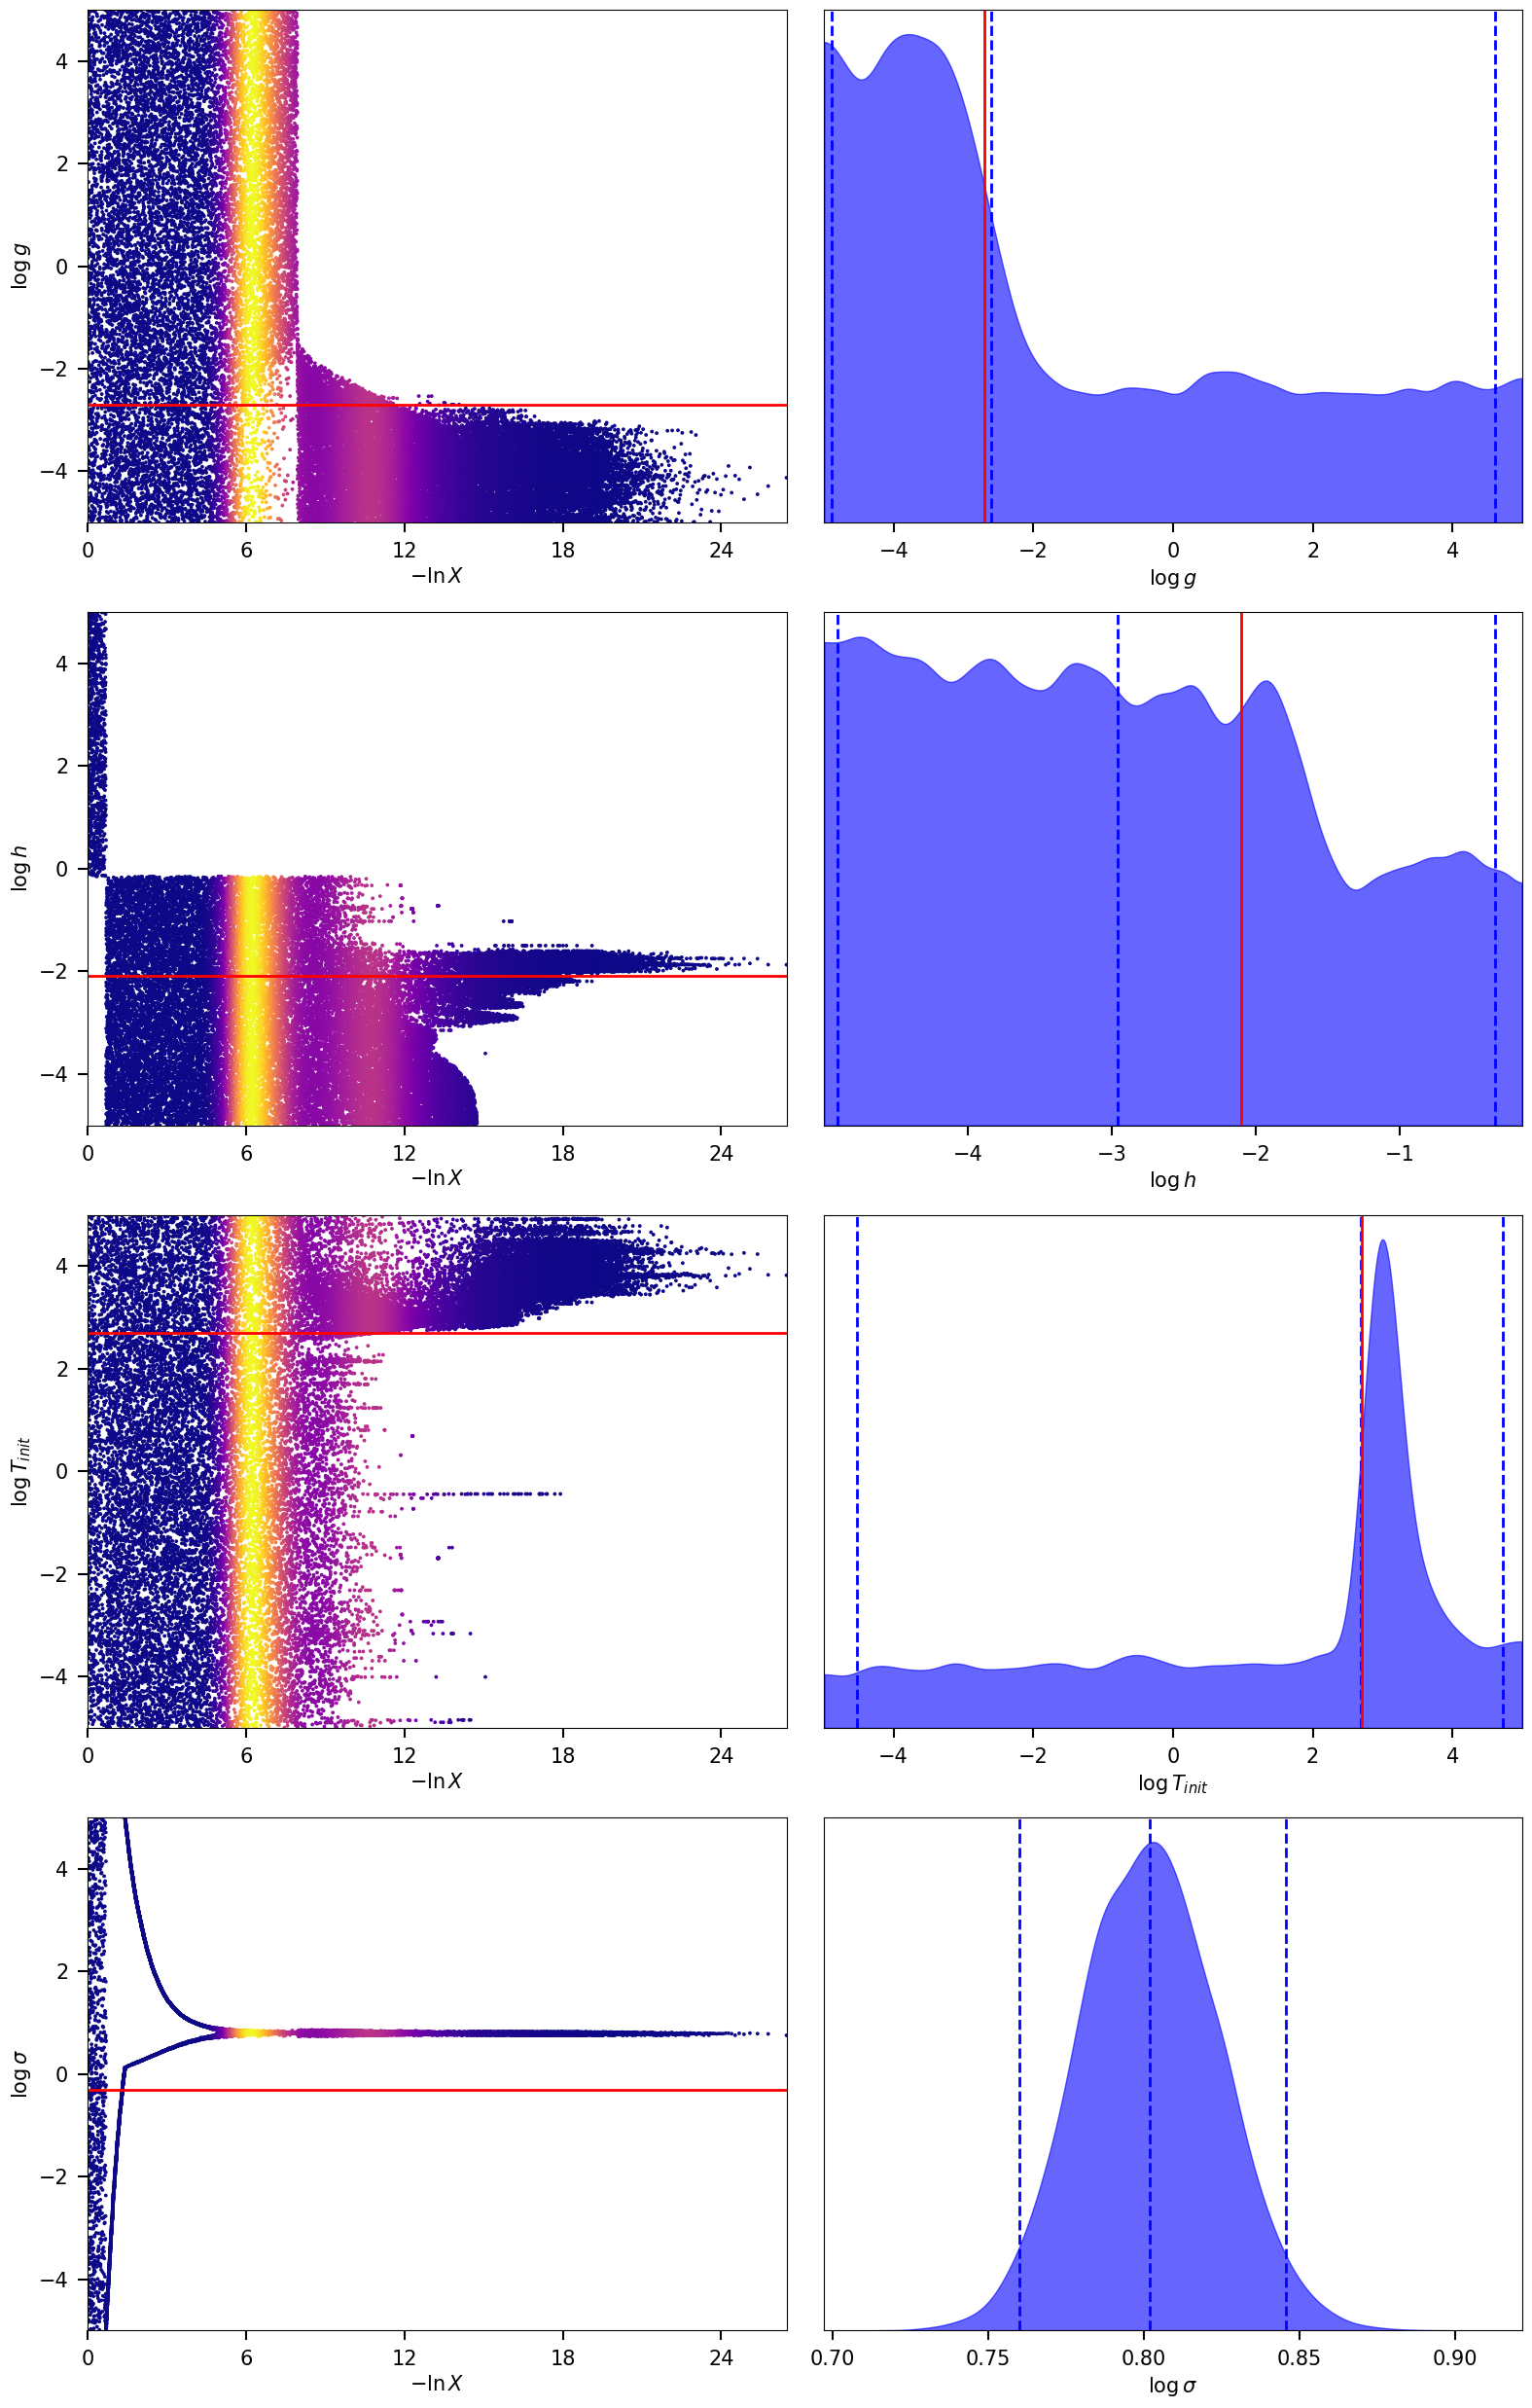

In [21]:
labels = [r'$\log g$', r'$\log h$', r'$\log T_{init}$', r'$\log \sigma$']
truths = [np.log10(0.002), np.log10(0.008), np.log10(500), np.log10(0.5)]
fig, axes = dyplot.traceplot(res, labels=labels, truths=truths,
                             fig=plt.subplots(4, 2, figsize=(16, 25)))
fig.tight_layout()

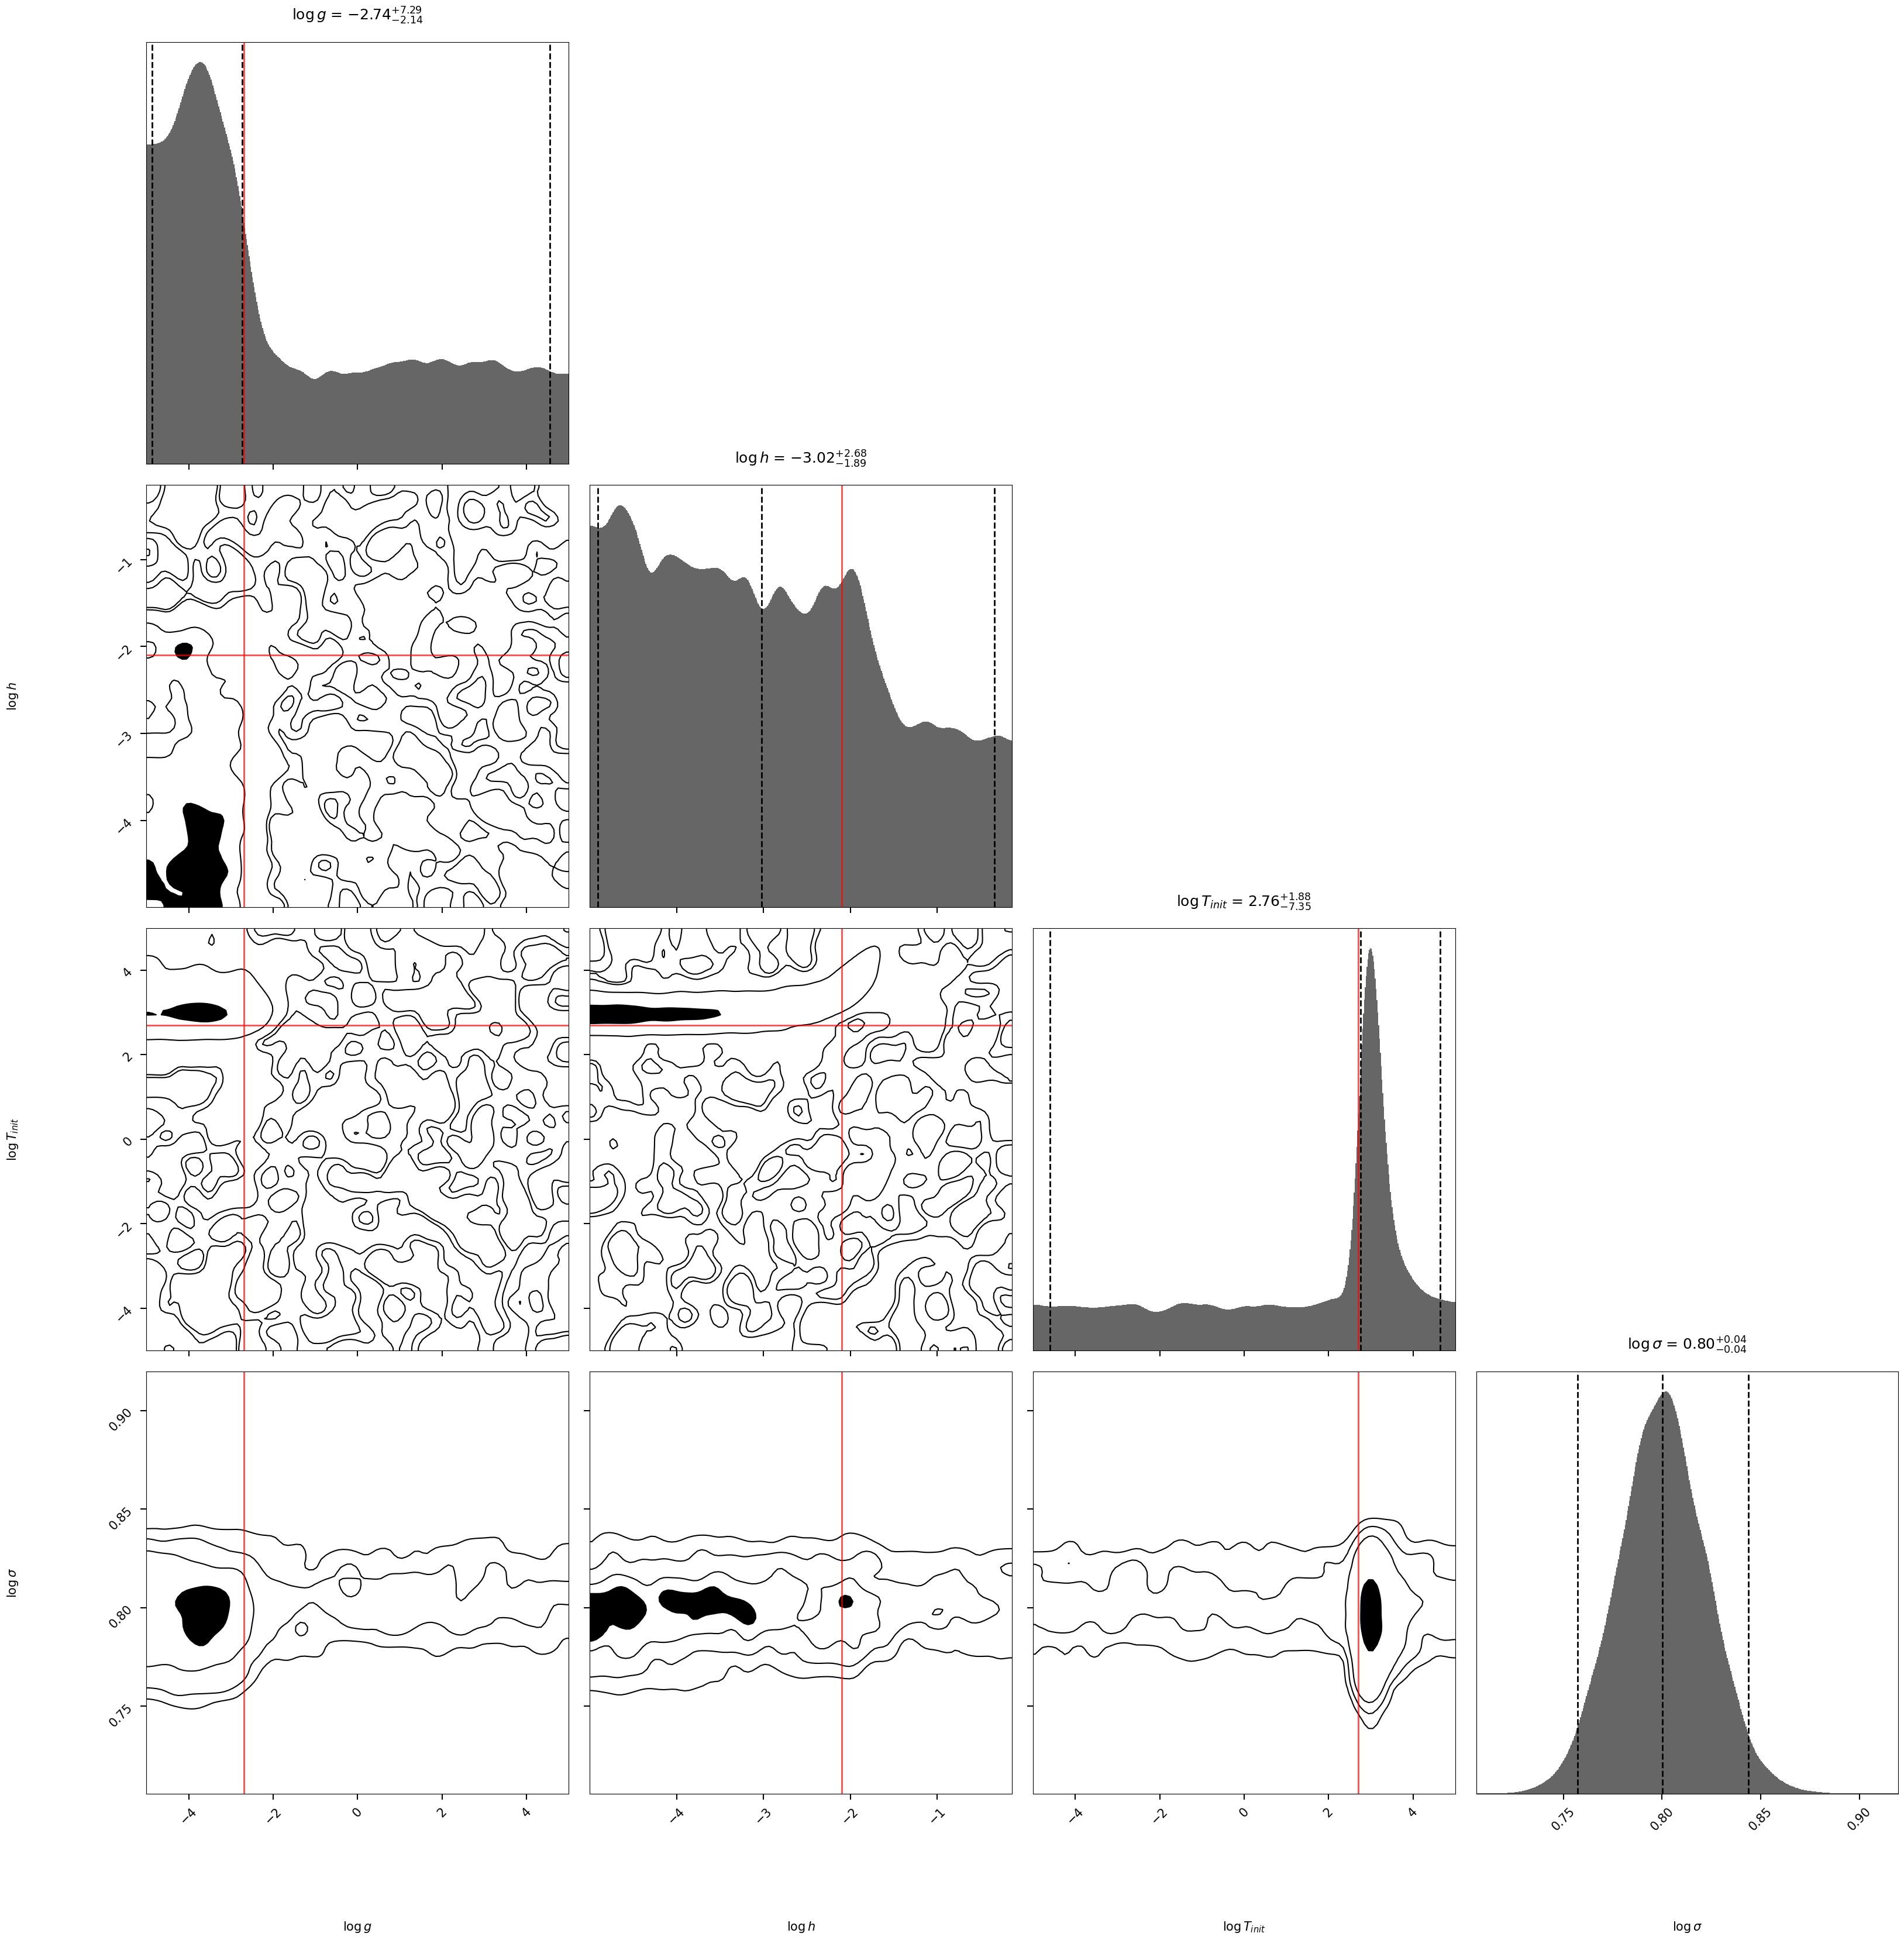

In [22]:
fig, axes = dyplot.cornerplot(respos, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(4,4, figsize=(35, 35)))